In [ ]:
!pip install z3-solver

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 63.9 MB/s eta 0:00:00


In [ ]:
from z3 import *

In [ ]:
# @title List edges
def list_edges(board):

  edges = []
  for r in range(len(board)):
    for c in range(len(board[0])):
      if board[r][c] != -1:
        for dr, dc in [(0,1), (1,0), (0,-1), (-1,0)]:
          nr, nc = r + dr, c + dc
          if 0 <= nr < len(board) and 0 <= nc < len(board[0]) and board[nr][nc] != -1 and (board[nr][nc], board[r][c]) not in edges:
            edges.append((board[r][c], board[nr][nc]))

  return edges

In [ ]:
# @title Example 1 - Easy

num_cells = 8

map = [
    [-1, -1, 0],
    [1, 2, 3],
    [-1, 4, 5],
    [-1, 6, 7],
]

cells = list(range(num_cells))

edges = list_edges(map)

dominos = [(4,1), (3,4), (1,3), (5,3)]


# Regions: list of regions, each = (cells_in_region, op, target)
# op could be "sum_eq", "sum_lt", "sum_gt", "all_eq", "all_diff", etc.
regions = [
    ([1], "sum_eq", 4),
    ([2,4,6], "all_eq", 0),
    ([0], "sum_eq", 4),
    ([3,5], "sum_lt", 3)
]

In [ ]:
# @title Example 2 - Medium

num_cells = 14

cells = list(range(num_cells))

map = [
    [0, -1, -1, -1, 1],
    [2, 3, -1, 4, 5],
    [6, 7, 8, 9, 10],
    [11, -1, 12, -1, 13]
]

edges = edges = list_edges(map)

dominos = [(0,4), (1,6), (2,3), (2,5), (1,1), (3,3), (5,4)]


# Regions: list of regions, each = (cells_in_region, op, target)
# op could be "sum_eq", "sum_lt", "sum_gt", "all_eq", "all_diff", etc.
regions = [
    ([0], "sum_gt", 3),
    ([3], "sum_gt", 2),
    ([6], "sum_gt", 4),
    ([8], "sum_gt", 4),
    ([12], "sum_gt", 1),
    ([1, 4, 5], "sum_eq", 7),
    ([10], "sum_gt", 4),
    ([13], "sum_gt", 2)
]

/tmp/ipython-input-1101373668.py:149: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


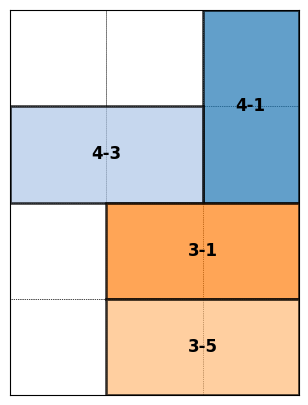

In [ ]:
# @title Solver and Visualization
solver = Solver()

D = len(dominos)
E = len(edges)

# Domino d is placed on edge e with orientation o (o = 0 means (a,b) and o = 1 means (b,a))
place = {}

for d in range(D):
  for e in range(E):
    for o in [0,1]:
      place[(d,e,o)] = Bool(f"place_{d}_{e}_{o}")

#Each cell value gets an int variable for its pip value, between 0 and 6 is the initial contraint

cell_val = [Int(f"v_{c}") for c in cells]
for c in cells:
    solver.add(And(cell_val[c] >= 0, cell_val[c] <= 6))

for d in range(D):
    choices = [place[(d, e, o)] for e in range(E) for o in [0, 1]]
    solver.add(AtLeast(*choices, 1))  # at least one
    solver.add(AtMost(*choices, 1))   # at most one
for d in range(D):
    choices = [place[(d, e, o)] for e in range(E) for o in [0, 1]]
    solver.add(AtLeast(*choices, 1))  # at least one
    solver.add(AtMost(*choices, 1))   # at most one
touches = {c: [] for c in cells}  # list of (bool_var, value)

for d, (a, b) in enumerate(dominos):
    for e, (c1, c2) in enumerate(edges):
        for o in [0, 1]:
            p = place[(d, e, o)]
            if o == 0:
                v1, v2 = a, b
            else:
                v1, v2 = b, a
            # c1 gets v1, c2 gets v2
            touches[c1].append((p, v1))
            touches[c2].append((p, v2))
for c in cells:
    # exactly one of the placements that touch c is used
    bools = [p for (p, v) in touches[c]]
    solver.add(AtLeast(*bools, 1))
    solver.add(AtMost(*bools, 1))

    # link cell_val[c] to those placements
    # If p is true, cell_val[c] == v
    # Because exactly one p is true, this pins down cell_val[c].
    constraints = []
    for (p, v) in touches[c]:
        constraints.append(Implies(p, cell_val[c] == v))

    solver.add(And(*constraints))

for cells_R, op, target in regions:
    vals = [cell_val[c] for c in cells_R]

    if op == "sum_eq":
        solver.add(Sum(vals) == target)

    elif op == "sum_lt":
        solver.add(Sum(vals) < target)

    elif op == "sum_gt":
        solver.add(Sum(vals) > target)

    elif op == "all_eq":   # all cells same value
        base = vals[0]
        solver.add(And([v == base for v in vals]))

    elif op == "all_diff": # all cells distinct
        solver.add(Distinct(vals))
if solver.check() == sat:
    model = solver.model()
    # Read out cell values
    solved_vals = [model[cell_val[c]].as_long() for c in cells]

    # And also which domino went where
    placements = []
    for d in range(D):
        for e in range(E):
            for o in [0, 1]:
                if model.evaluate(place[(d, e, o)], model_completion=True):
                    placements.append((d, e, o))
    # Now you know exactly which domino is on which edge and orientation
else:
  placements = None
  print("No solution.")

# @title Visualization
rows = len(map)
cols = len(map[0])

# node_id -> (row, col)
node_pos = {}
for r, row in enumerate(map):
    for c, val in enumerate(row):
        if val != -1:
            node_pos[val] = (r, c)

def placements_to_tiles(placements, dominos, edges, node_pos):
    tiles = []
    for dom_idx, edge_idx, flipped in placements:
        # Domino numbers
        a, b = dominos[dom_idx]
        if flipped == 1:
            a, b = b, a

        # Edge endpoints (node ids)
        n1, n2 = edges[edge_idx]

        # Convert node ids to (row, col)
        c1 = node_pos[n1]
        c2 = node_pos[n2]

        # Label shown on the tile - change to a+b if you want the sum
        label = f"{a}-{b}"   # or str(dom_idx), or a+b, etc.

        tiles.append({
            "cells": [c1, c2],
            "value": label,
        })

    return tiles
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_board(rows, cols, tiles, figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlim(0, cols)
    ax.set_ylim(0, rows)
    ax.set_aspect("equal")
    ax.invert_yaxis()

    # Draw grid
    for r in range(rows):
        for c in range(cols):
            rect = patches.Rectangle(
                (c, r), 1, 1,
                fill=False,
                linewidth=0.5,
                linestyle=":"
            )
            ax.add_patch(rect)

    cmap = plt.cm.get_cmap("tab20")
    for i, tile in enumerate(tiles):
        cells = tile["cells"]
        color = cmap(i % 20)

        rows_ = [r for (r, c) in cells]
        cols_ = [c for (r, c) in cells]
        min_r, max_r = min(rows_), max(rows_)
        min_c, max_c = min(cols_), max(cols_)
        x, y = min_c, min_r
        w = max_c - min_c + 1
        h = max_r - min_r + 1

        rect = patches.Rectangle(
            (x, y), w, h,
            linewidth=2,
            edgecolor="black",
            facecolor=color,
            alpha=0.7,
        )
        ax.add_patch(rect)

        value = tile.get("value", "")
        cx = x + w / 2
        cy = y + h / 2
        ax.text(cx, cy, str(value), ha="center", va="center",
                fontsize=12, weight="bold")

    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
tiles = placements_to_tiles(placements, dominos, edges, node_pos)
plot_board(rows, cols, tiles)